In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(most_recent_date)

2017-08-23


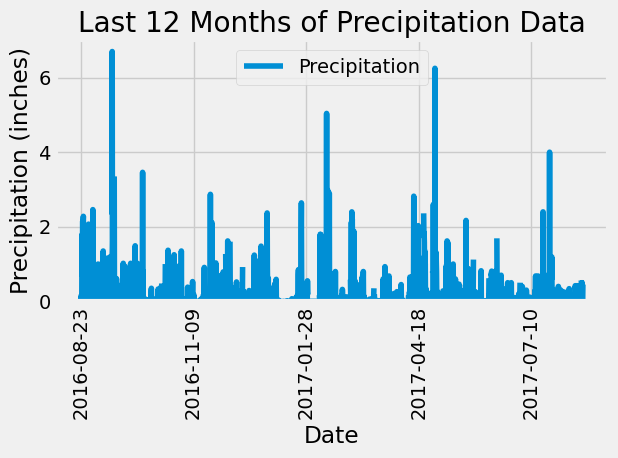

In [10]:
# Design a query to retrieve the last 12 months of precipitation data
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago_date = most_recent_date - dt.timedelta(days=366)

last_12_months = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago_date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_12_months_df = pd.DataFrame(last_12_months, columns=['Date', 'Precipitation'])
last_12_months_df.set_index('Date',inplace=True)
# last_12_months_df = last_12_months_df.dropna(subset=['Precipitation'])

# Sort the dataframe by date
last_12_months_df = last_12_months_df.sort_values('Date')
# Plot the results using Matplotlib
last_12_months_df.plot()
plt.title("Last 12 Months of Precipitation Data")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.ylim(0, 7)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_12_months_df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations=session.query(Station.id).count()
total_stations

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
            .group_by(Measurement.station)\
            .order_by(func.count(Measurement.station).desc())\
            .all()

for result in most_active_stations:
    print(result)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id=session.query(Measurement.station, func.count(Measurement.station))\
            .group_by(Measurement.station)\
            .order_by(func.count(Measurement.station).desc())\
            .first()[0]
temp=session.query(func.min(Measurement.tobs),
                          func.max(Measurement.tobs),
                          func.avg(Measurement.tobs))\
                          .filter(Measurement.station==most_active_station_id)
for record in temp:
    print(record)

(54.0, 85.0, 71.66378066378067)


In [15]:
start_list = []
for result in temp:
    start_dict = {}
    start_dict['Minimum Temperature'] = result[0]
    start_dict['Average Temperature'] = result[1]
    start_dict['Maximum Temperature'] = result[2]
    start_list.append(start_dict)

start_list

[{'Minimum Temperature': 54.0,
  'Average Temperature': 85.0,
  'Maximum Temperature': 71.66378066378067}]

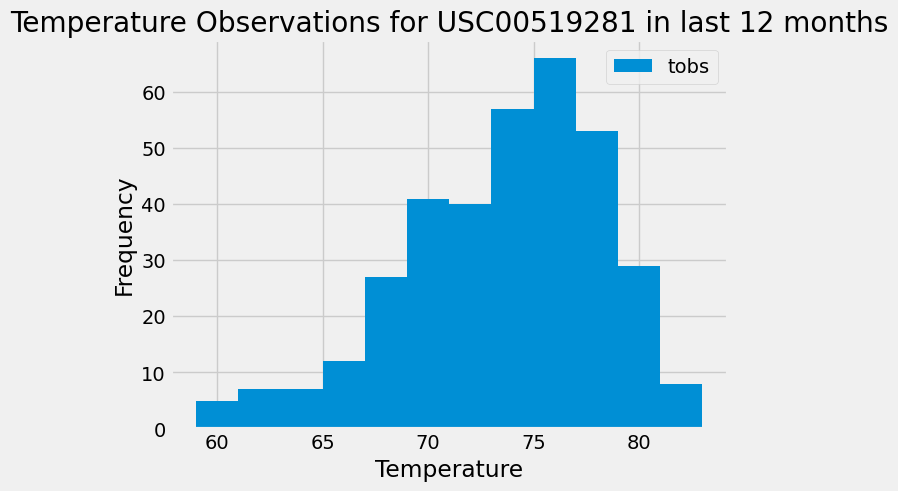

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_last_12_months=session.query(Measurement.tobs)\
                    .filter(Measurement.station==most_active_station_id)\
                    .filter(Measurement.date >= one_year_ago_date)\
                    .order_by(Measurement.date)\
                    .all()
tobs_last_12_months_df=pd.DataFrame(tobs_last_12_months)
tobs_last_12_months_df.hist(column='tobs',bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.title(f'Temperature Observations for {most_active_station_id} in last 12 months')
plt.show()

# Close Session

In [17]:
# Close Session
session.close()